In [49]:
import sys
import pandas as pd
import matplotlib
import numpy as np
import scipy as sp
import IPython
from IPython import display
import sklearn
import random
import time
import warnings
warnings.filterwarnings('ignore')

In [50]:
from sklearn import svm,tree,linear_model,neighbors,naive_bayes,ensemble,discriminant_analysis,gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
plt.rcParams['figure.figsize'] = 12,8

In [51]:
data_raw = pd.read_csv('train.csv')
data_val = pd.read_csv('test.csv')

data1 = data_raw.copy(deep=True)#一括処理のためにまとめてる,Trueは元データを崩さない
data_cleaner = [data1,data_val]#2つのDataFrameへの参照を格納したリスト

print(data_raw.info())
data_raw.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
589,590,0,3,"Murdlin, Mr. Joseph",male,NaN,0,0,A./5. 3235,8.0500,NaN,S
321,322,0,3,"Danoff, Mr. Yoto",male,27.0,0,0,349219,7.8958,NaN,S
761,762,0,3,"Nirva, Mr. Iisakki Antino Aijo",male,41.0,0,0,SOTON/O2 3101272,7.1250,NaN,S
451,452,0,3,"Hagland, Mr. Ingvald Olai Olsen",male,NaN,1,0,65303,19.9667,NaN,S
264,265,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
181,182,0,2,"Pernot, Mr. Rene",male,NaN,0,0,SC/PARIS 2131,15.0500,NaN,C
367,368,1,3,"Moussa, Mrs. (Mantoura Boulos)",female,NaN,0,0,2626,7.2292,NaN,C
800,801,0,2,"Ponesell, Mr. Martin",male,34.0,0,0,250647,13.0000,NaN,S
495,496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.5500,NaN,S


In [52]:
print(data1.isna().sum())
print("-"*10)
print(data_val.isnull().sum())
data_raw.describe(include='all')

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [53]:
#データの処理
#Ageの欄のNAには中央値を入れる,embarkedには最頻値,Fareには中央値
for dataset in data_cleaner:
    dataset['Age'].fillna(dataset['Age'].median(),inplace=True)

    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0],inplace=True)

    dataset['Fare'].fillna(dataset['Fare'].median(),inplace=True)
#列で必要なさそうなのを削除
drop_column = ['PassengerId','Cabin','Ticket']
data1.drop(drop_column,axis=1,inplace=True)

print(data1.isnull().sum())
print("-"*10)
print(data_val.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


In [54]:
#FamilySize,IsAlone,Title,FareBin,AgeBinをいじる
for dataset in data_cleaner:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['IsAlone'] = 1
    dataset['IsAlone'].loc[dataset['FamilySize']>1] = 0
    #敬称だけを取り出してる
    dataset['Title'] = dataset['Name'].str.split(",",expand=True)[1].str.split(".",expand=True)[0]#expand=TrueだとDataFrameでFalseだとリストのまま
    dataset['FareBin'] = pd.qcut(dataset['Fare'],4)#qcutは同じ量に分ける
    dataset['AgeBin'] = pd.cut(dataset['Age'].astype(int),5)#cutは分ける分布を等間隔で区切る

stat_min = 10
title_names = (data1['Title'].value_counts()<stat_min)
#10件未満のtitleはMiscにまとめる
data1['Title'] = data1['Title'].apply(lambda x:'Misc' if title_names.loc[x]==True else x)
print(data1['Title'].value_counts())
print("-"*10)

data1.info()
data_val.info()
data1.sample(10)

Title
 Mr        517
 Miss      182
 Mrs       125
 Master     40
Misc        27
Name: count, dtype: int64
----------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   Survived    891 non-null    int64   
 1   Pclass      891 non-null    int64   
 2   Name        891 non-null    object  
 3   Sex         891 non-null    object  
 4   Age         891 non-null    float64 
 5   SibSp       891 non-null    int64   
 6   Parch       891 non-null    int64   
 7   Fare        891 non-null    float64 
 8   Embarked    891 non-null    object  
 9   FamilySize  891 non-null    int64   
 10  IsAlone     891 non-null    int64   
 11  Title       891 non-null    object  
 12  FareBin     891 non-null    category
 13  AgeBin      891 non-null    category
dtypes: category(2), float64(2), int64(6), object(4)
memory usage: 85.9+ KB
<class 'pandas.core.frame.Dat

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin
280,0,3,"Duane, Mr. Frank",male,65.0,0,0,7.7500,Q,1,1,Mr,"(-0.001, 7.91]","(64.0, 80.0]"
701,1,1,"Silverthorne, Mr. Spencer Victor",male,35.0,0,0,26.2875,S,1,1,Mr,"(14.454, 31.0]","(32.0, 48.0]"
462,0,1,"Gee, Mr. Arthur H",male,47.0,0,0,38.5000,S,1,1,Mr,"(31.0, 512.329]","(32.0, 48.0]"
855,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,9.3500,S,2,0,Mrs,"(7.91, 14.454]","(16.0, 32.0]"
725,0,3,"Oreskovic, Mr. Luka",male,20.0,0,0,8.6625,S,1,1,Mr,"(7.91, 14.454]","(16.0, 32.0]"
559,1,3,"de Messemaeker, Mrs. Guillaume Joseph (Emma)",female,36.0,1,0,17.4000,S,2,0,Mrs,"(14.454, 31.0]","(32.0, 48.0]"
362,0,3,"Barbara, Mrs. (Catherine David)",female,45.0,0,1,14.4542,C,2,0,Mrs,"(7.91, 14.454]","(32.0, 48.0]"
403,0,3,"Hakkarainen, Mr. Pekka Pietari",male,28.0,1,0,15.8500,S,2,0,Mr,"(14.454, 31.0]","(16.0, 32.0]"
704,0,3,"Hansen, Mr. Henrik Juul",male,26.0,1,0,7.8542,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]"
65,1,3,"Moubarek, Master. Gerios",male,28.0,1,1,15.2458,C,3,0,Master,"(14.454, 31.0]","(16.0, 32.0]"


In [55]:
#カテゴリーを数値型に変換
label = LabelEncoder()
for dataset in data_cleaner:
    dataset['Sex_Code'] = label.fit_transform(dataset['Sex'])
    dataset['Embarked_Code'] = label.fit_transform(dataset['Embarked'])
    dataset['Title_Code'] = label.fit_transform(dataset['Title'])
    dataset['AgeBin_Code'] = label.fit_transform(dataset['Age'])
    dataset['FareBin_Code'] = label.fit_transform(dataset['FareBin'])

Target = ['Survived']
#元のカテゴリを含む生データ
data1_x = ['Sex','Pclass','Embarked','Title','SibSp','Parch','Age','Fare','FamilySize','IsAlone']
#ラベルエンコード済みの数値データ
data1_x_calc = ['Sex_Code','Pclass','Embarked_Code','Title_Code','SibSp','Parch','Age','Fare']
data1_xy = Target + data1_x
print('Original X Y:',data1_xy,'\n')

#ビン化された変数を含む
data1_x_bin = ['Sex_Code','Pclass','Embarked_Code','Title_Code','FamilySize','AgeBin_Code','FareBin_Code']
data1_xy_bin = Target + data1_x_bin
print('Bin X Y;:',data1_xy_bin,'\n')

#ダミー形式
data1_dummy = pd.get_dummies(data1[data1_x])#各カテゴリを0or1
data1_x_dummy = data1_dummy.columns.tolist()
data1_xy_dummy = Target + data1_x_dummy
print('Dummy X Y:',data1_xy_dummy,'\n')

data1_dummy.head()

Original X Y: ['Survived', 'Sex', 'Pclass', 'Embarked', 'Title', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone'] 

Bin X Y;: ['Survived', 'Sex_Code', 'Pclass', 'Embarked_Code', 'Title_Code', 'FamilySize', 'AgeBin_Code', 'FareBin_Code'] 

Dummy X Y: ['Survived', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'FamilySize', 'IsAlone', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_ Master', 'Title_ Miss', 'Title_ Mr', 'Title_ Mrs', 'Title_Misc'] 



,Pclass,SibSp,Parch,Age,Fare,FamilySize,IsAlone,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Title_ Master,Title_ Miss,Title_ Mr,Title_ Mrs,Title_Misc
0,3,1,0,22.0,7.2500,2,0,False,True,False,False,True,False,False,True,False,False
1,1,1,0,38.0,71.2833,2,0,True,False,True,False,False,False,False,False,True,False
2,3,0,0,26.0,7.9250,1,1,True,False,False,False,True,False,True,False,False,False
3,1,1,0,35.0,53.1000,2,0,True,False,False,False,True,False,False,False,True,False
4,3,0,0,35.0,8.0500,1,1,False,True,False,False,True,False,False,True,False,False


In [56]:
#一応チェック
print('Train columns with null values:\n',data1.isnull().sum())
print("-"*20)
print(data1.info())
print("-"*20)

print('Test/Validation columns with null values:\n',data_val.isnull().sum())
print("-"*20)

data_raw.describe(include='all')

Train columns with null values:
 Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
FamilySize       0
IsAlone          0
Title            0
FareBin          0
AgeBin           0
Sex_Code         0
Embarked_Code    0
Title_Code       0
AgeBin_Code      0
FareBin_Code     0
dtype: int64
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Survived       891 non-null    int64   
 1   Pclass         891 non-null    int64   
 2   Name           891 non-null    object  
 3   Sex            891 non-null    object  
 4   Age            891 non-null    float64 
 5   SibSp          891 non-null    int64   
 6   Parch          891 non-null    int64   
 7   Fare           891 non-null    float64 
 8   Embarked    

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [57]:
#トレーニングデータとテストデータに分割
train1_x,test1_x,train1_y,test1_y = model_selection.train_test_split(data1[data1_x_calc],
                                                                     data1[Target],random_state=0)
train1_x_bin,test1_x_bin,train1_y_bin,test1_y_bin = model_selection.train_test_split(data1[data1_x_bin],
                                                                                     data1[Target],random_state=0)
train1_x_dummy,test1_x_dummy,train1_y_dummy,test1_y_dummy = model_selection.train_test_split(data1_dummy[data1_x_dummy],
                                                                                             data1[Target],random_state=0)
print(f"Data1 Shape: {data1.shape}")
print(f"Train1 Shape: {train1_x.shape}")
print(f"Test1 Shape: {test1_x.shape}")

train1_x_bin.head()

Data1 Shape: (891, 19)
Train1 Shape: (668, 8)
Test1 Shape: (223, 8)


,Sex_Code,Pclass,Embarked_Code,Title_Code,FamilySize,AgeBin_Code,FareBin_Code
105,1,3,2,2,1,36,0
68,0,3,2,1,7,22,1
253,1,3,2,2,2,39,2
320,1,3,2,2,1,28,0
706,0,2,2,3,1,59,1


In [58]:
#EDA
#カテゴリ変数ごとの生存率の傾向
for x in data1_x:
    if data1[x].dtype != 'float64':
        print('Survival Correlation by:',x)
        print(data1[[x,Target[0]]].groupby(x,as_index=False).mean())
        print("-"*20,"\n")
#クロス集計
pd.crosstab(data1['Title'],data1[Target[0]]).style.background_gradient(cmap='summer_r')

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
-------------------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
-------------------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
-------------------- 

Survival Correlation by: Title
     Title  Survived
0   Master  0.575000
1     Miss  0.697802
2       Mr  0.156673
3      Mrs  0.792000
4     Misc  0.444444
-------------------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
-------------------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
-------------------- 

Survival Correlation

Survived,0,1
Title,,
Master,17,23
Miss,55,127
Mr,436,81
Mrs,26,99
Misc,15,12


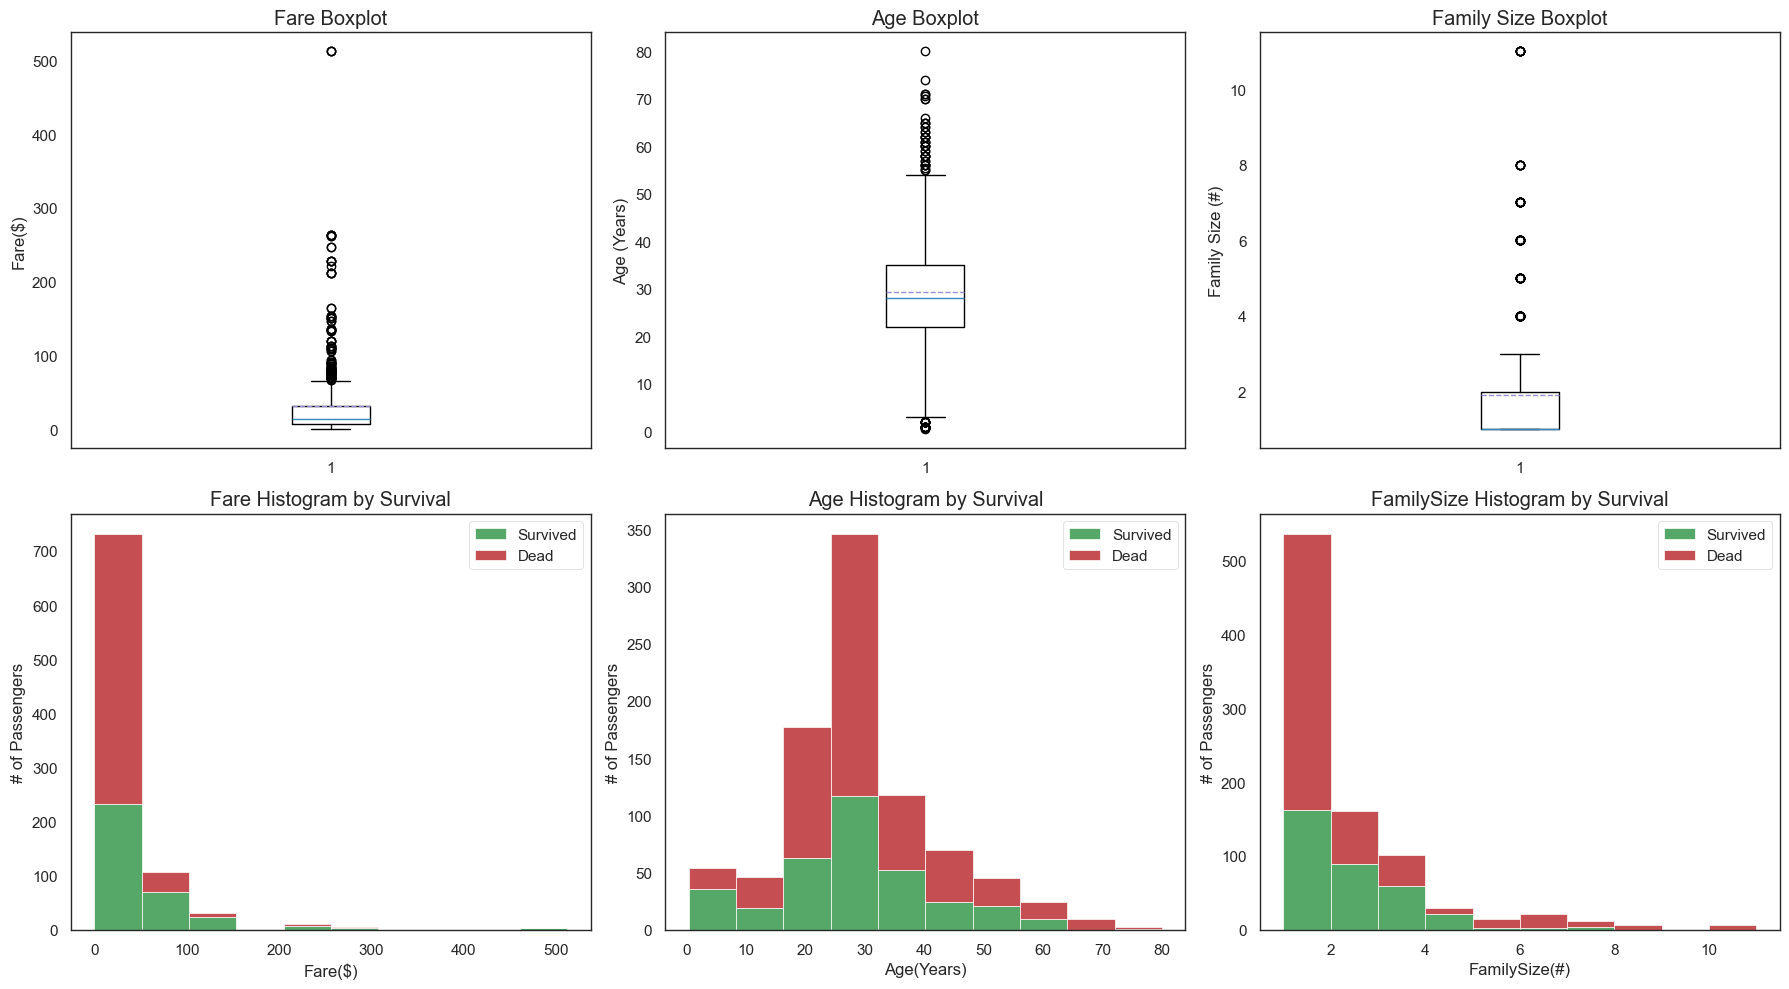

In [59]:
#視覚化
fig,axes = plt.subplots(2,3,figsize=(18,10))
#FareのBoxplot
axes[0,0].boxplot(data1['Fare'],showmeans=True,meanline=True)
axes[0,0].set_title('Fare Boxplot')
axes[0,0].set_ylabel('Fare($)')

#AgeのBoxplot
axes[0,1].boxplot(data1['Age'],showmeans=True,meanline=True)
axes[0,1].set_title('Age Boxplot')
axes[0,1].set_ylabel('Age (Years)')

#FamilySizeのBoxplot
axes[0,2].boxplot(data1['FamilySize'],showmeans=True,meanline=True)
axes[0,2].set_title('Family Size Boxplot')
axes[0,2].set_ylabel('Family Size (#)')

#Fareの生存者に関するヒストグラム
axes[1,0].hist(
    [data1[data1['Survived']==1]['Fare'],data1[data1['Survived']==0]['Fare']],
    stacked=True,color=['g','r'],label=['Survived','Dead']
)
axes[1,0].set_title('Fare Histogram by Survival')
axes[1,0].set_xlabel('Fare($)')
axes[1,0].set_ylabel('# of Passengers')
axes[1,0].legend()

#Ageの生存者に関するヒストグラム
axes[1,1].hist(
    [data1[data1['Survived']==1]['Age'],data1[data1['Survived']==0]['Age']],
    stacked=True,color=['g','r'],label=['Survived','Dead']
)
axes[1,1].set_title('Age Histogram by Survival')
axes[1,1].set_xlabel('Age(Years)')
axes[1,1].set_ylabel('# of Passengers')
axes[1,1].legend()

#FamilySizeの生存者に関するヒストグラム
axes[1,2].hist(
    [data1[data1['Survived']==1]['FamilySize'],data1[data1['Survived']==0]['FamilySize']],
    stacked=True,color=['g','r'],label=['Survived','Dead']
)
axes[1,2].set_title('FamilySize Histogram by Survival')
axes[1,2].set_xlabel('FamilySize(#)')
axes[1,2].set_ylabel('# of Passengers')
axes[1,2].legend()
plt.tight_layout()
plt.show()

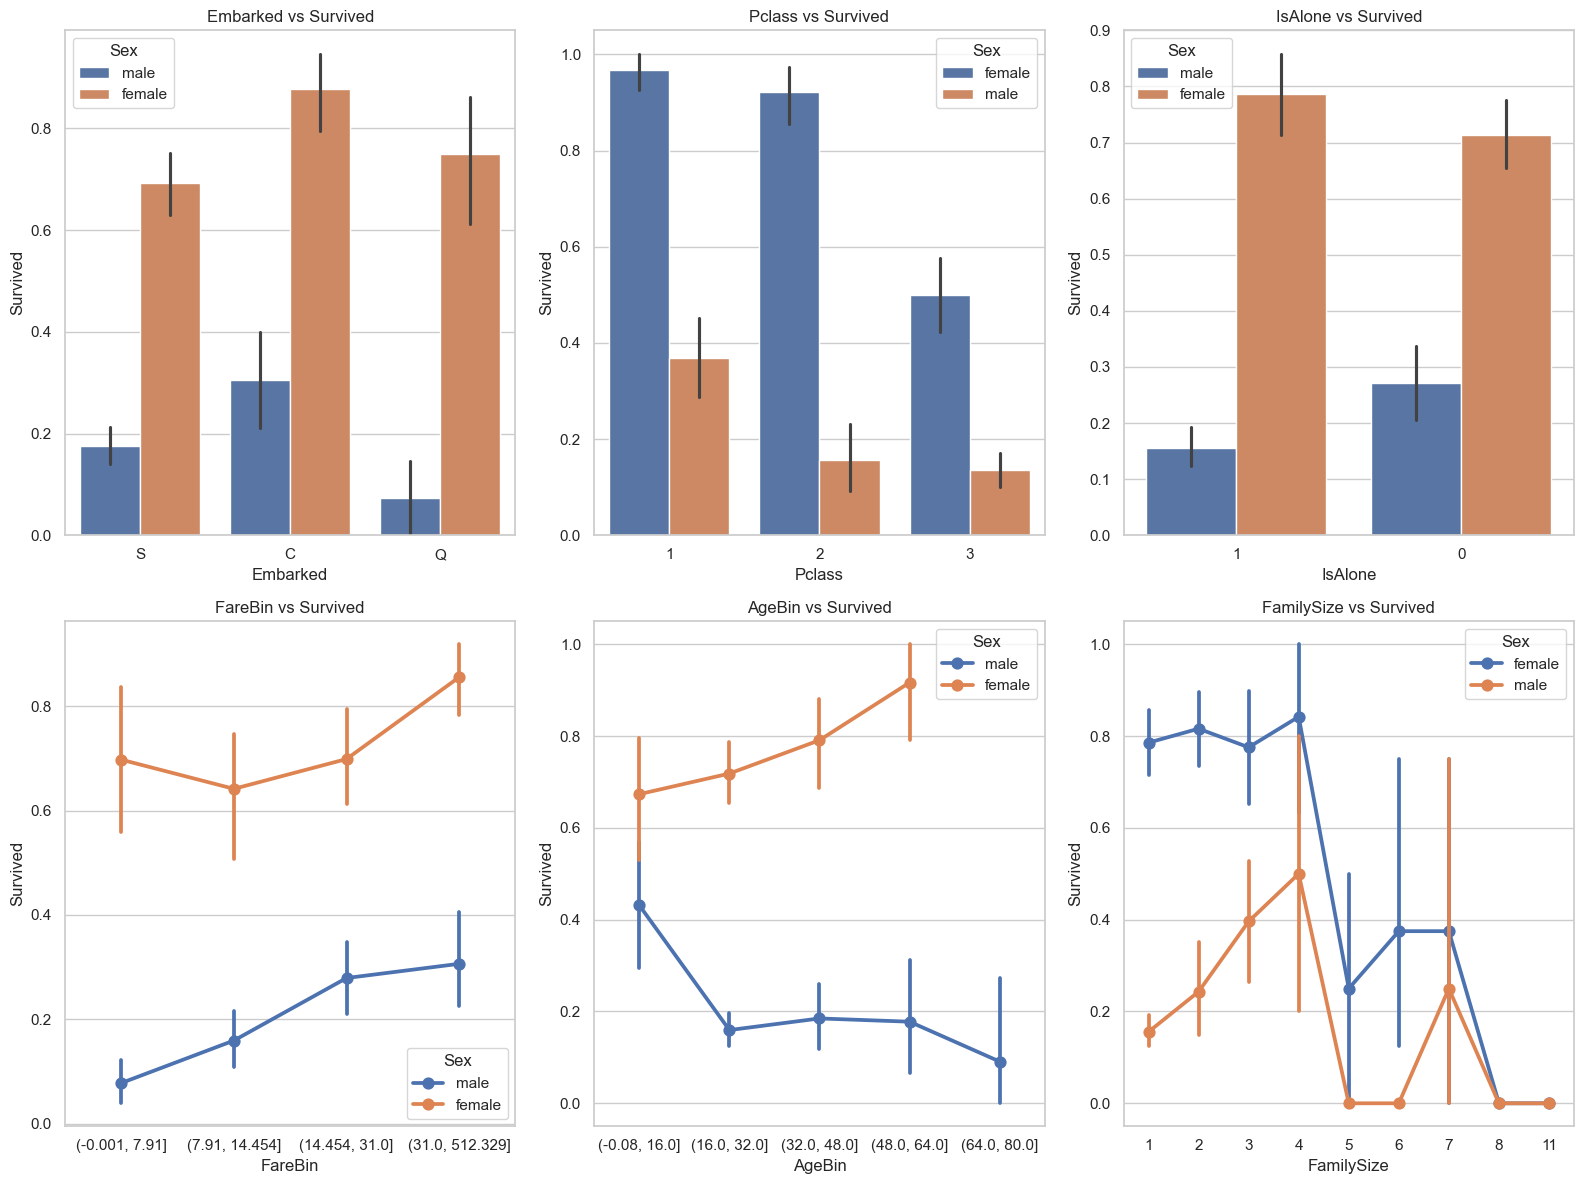

In [60]:
#描画の設定
sns.set_theme(style='whitegrid')
fig,axes = plt.subplots(2,3,figsize=(16,12))

#カテゴリ変数のBarplot
bar_features = [('Embarked',None),('Pclass',[1,2,3]),('IsAlone',[1,0])]
for i,(feature,order) in enumerate(bar_features):
    sns.barplot(
        x=feature,
        y='Survived',
        data=data1,
        order=order,
        ax=axes[0,i],
        hue='Sex'
    )
    axes[0,i].set_title(f'{feature} vs Survived')
#数値変数のpointplot
point_features = ['FareBin','AgeBin','FamilySize']
for i,feature in enumerate(point_features):
    sns.pointplot(
        x=feature,
        y='Survived',
        data=data1,
        ax=axes[1,i],
        hue='Sex'
    )
    axes[1,i].set_title(f'{feature} vs Survived')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Pclass vs Family Size Survival Comparison')

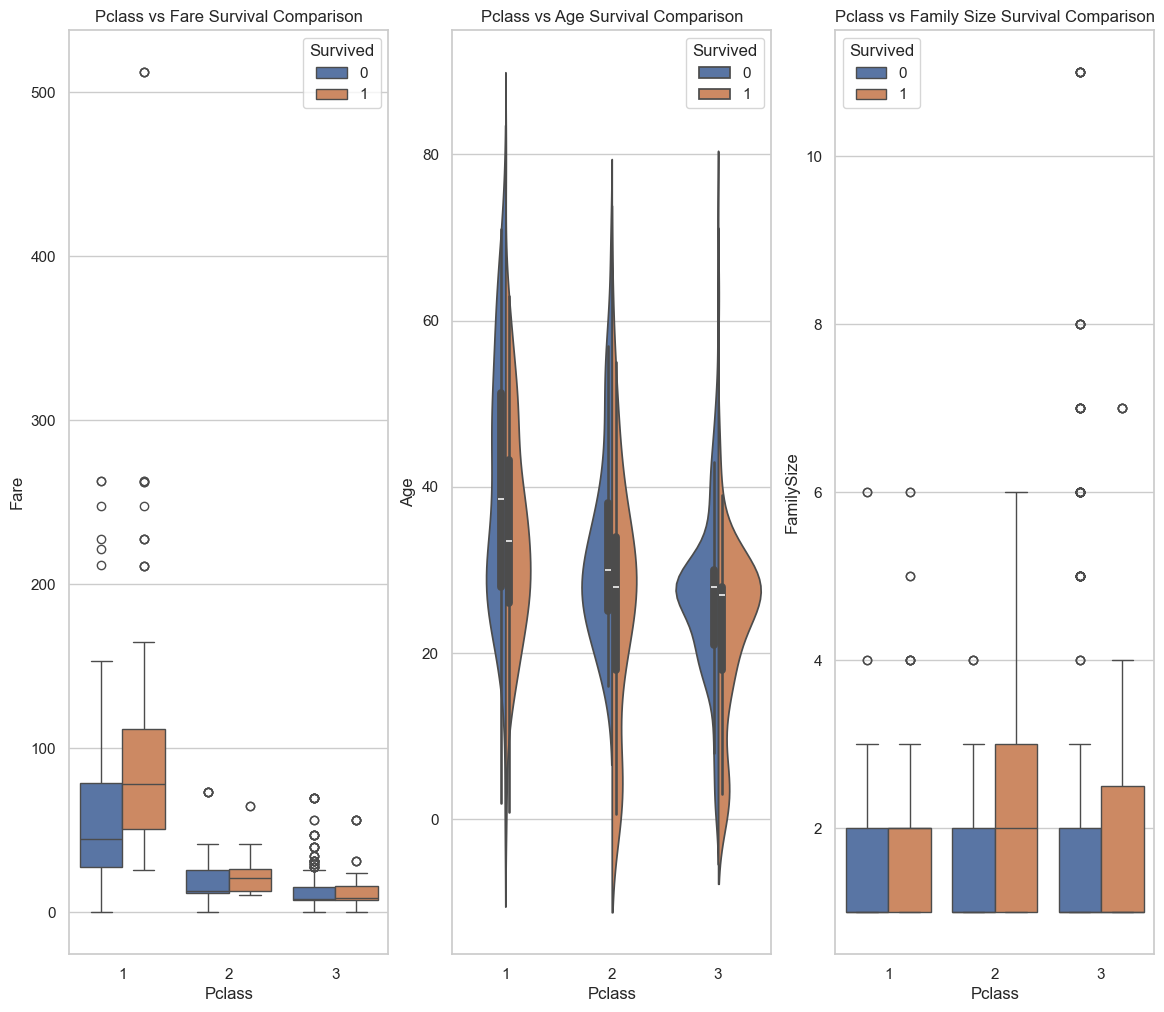

In [61]:
#乗客クラスと他の特徴量の関係を可視化
fig, (axis1,axis2,axis3) = plt.subplots(1,3,figsize=(14,12))

sns.boxplot(x = 'Pclass', y = 'Fare', hue = 'Survived', data = data1, ax = axis1)
axis1.set_title('Pclass vs Fare Survival Comparison')

sns.violinplot(x = 'Pclass', y = 'Age', hue = 'Survived', data = data1, split = True, ax = axis2)
axis2.set_title('Pclass vs Age Survival Comparison')

sns.boxplot(x = 'Pclass', y ='FamilySize', hue = 'Survived', data = data1, ax = axis3)
axis3.set_title('Pclass vs Family Size Survival Comparison')

Text(0.5, 1.0, 'Sex vs IsAlone Survival Comparison')

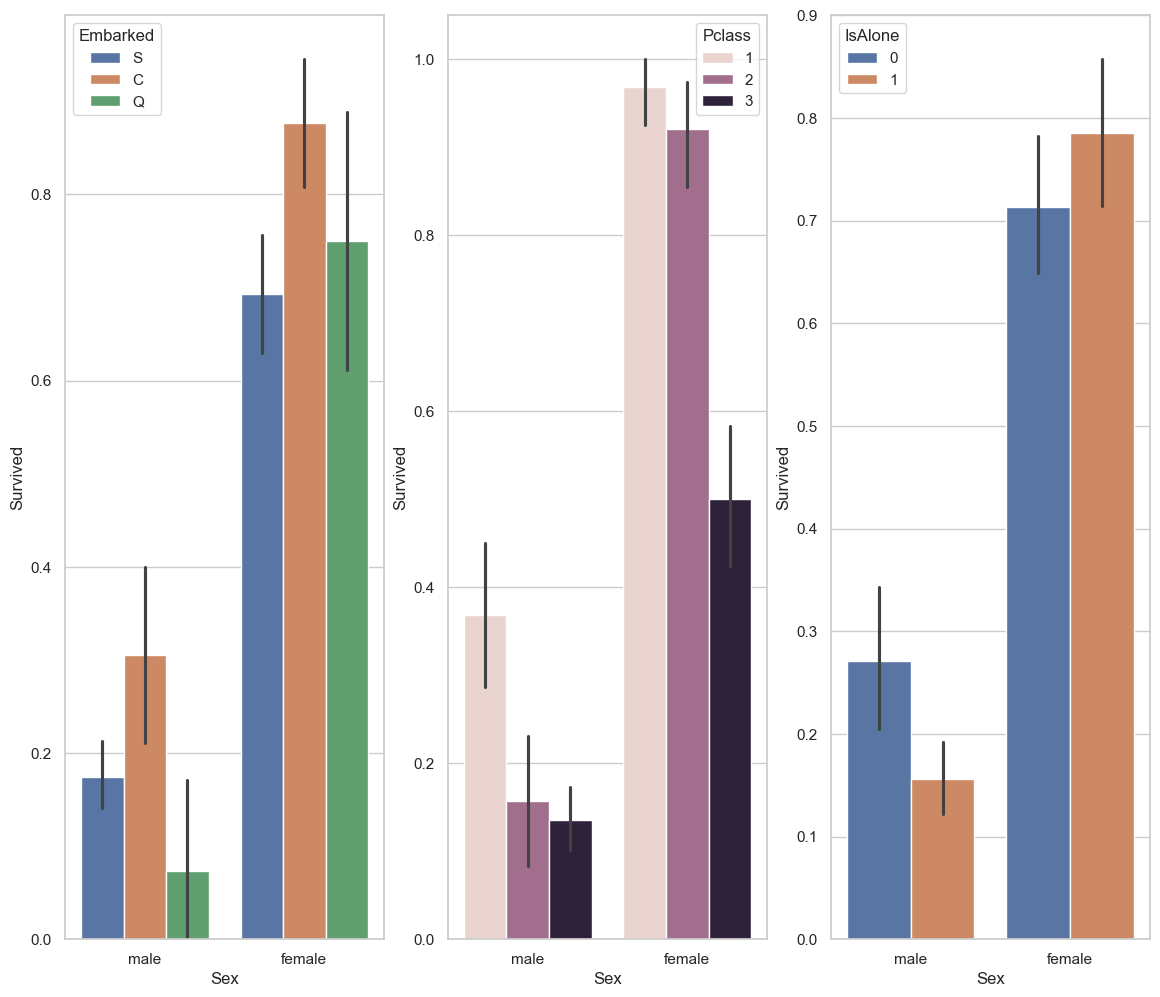

In [62]:
#3つのカテゴリ変数ごとに性別と生存率の関係を可視化
fig, qaxis = plt.subplots(1,3,figsize=(14,12))

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Embarked', data=data1, ax = qaxis[0])
axis1.set_title('Sex vs Embarked Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'Pclass', data=data1, ax  = qaxis[1])
axis1.set_title('Sex vs Pclass Survival Comparison')

sns.barplot(x = 'Sex', y = 'Survived', hue = 'IsAlone', data=data1, ax  = qaxis[2])
axis1.set_title('Sex vs IsAlone Survival Comparison')

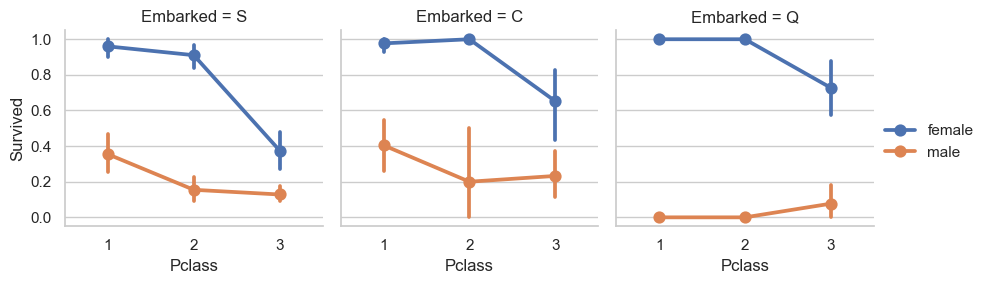

In [63]:
e = sns.FacetGrid(data1, col = 'Embarked')#港ごとにグラフを分割
#ciは信頼区間、paletteは色を見やすくしてる
e.map_dataframe(sns.pointplot, 'Pclass', 'Survived', hue='Sex',hue_order=['female','male'] ,ci=95.0, palette = 'deep')
e.add_legend()

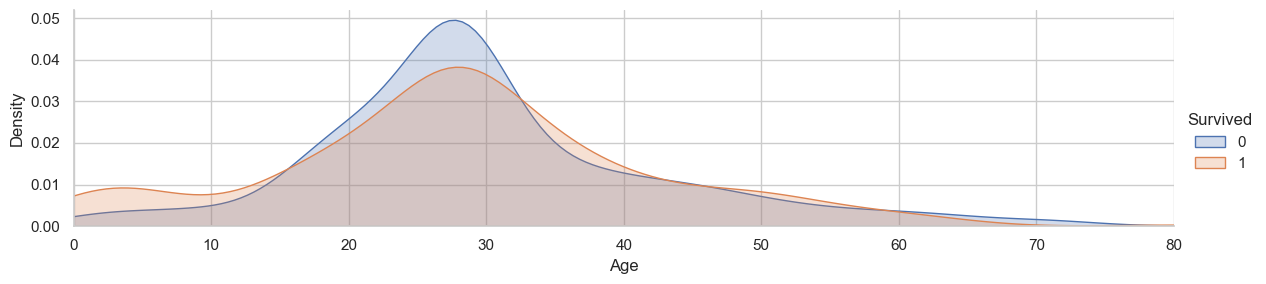

In [64]:
a = sns.FacetGrid( data1, hue = 'Survived', aspect=4 )
#FacetGridはカテゴリ変数ごとに分割表示したい時に使う
a.map_dataframe(sns.kdeplot, 'Age', shade= True )
a.set(xlim=(0 , data1['Age'].max()))
a.add_legend()

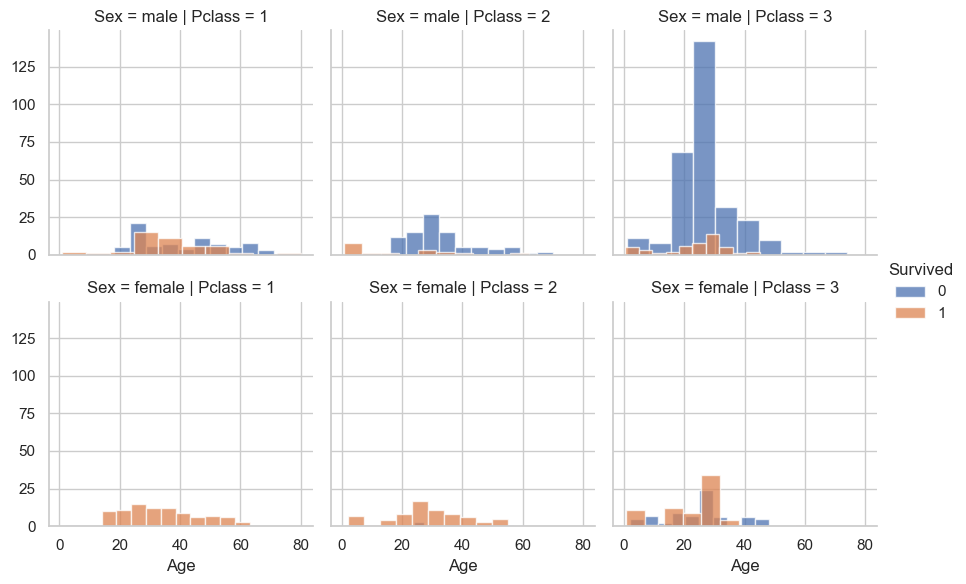

In [65]:
h = sns.FacetGrid(data1, row = 'Sex', col = 'Pclass', hue = 'Survived')
h.map_dataframe(plt.hist, 'Age', alpha = .75)
h.add_legend()

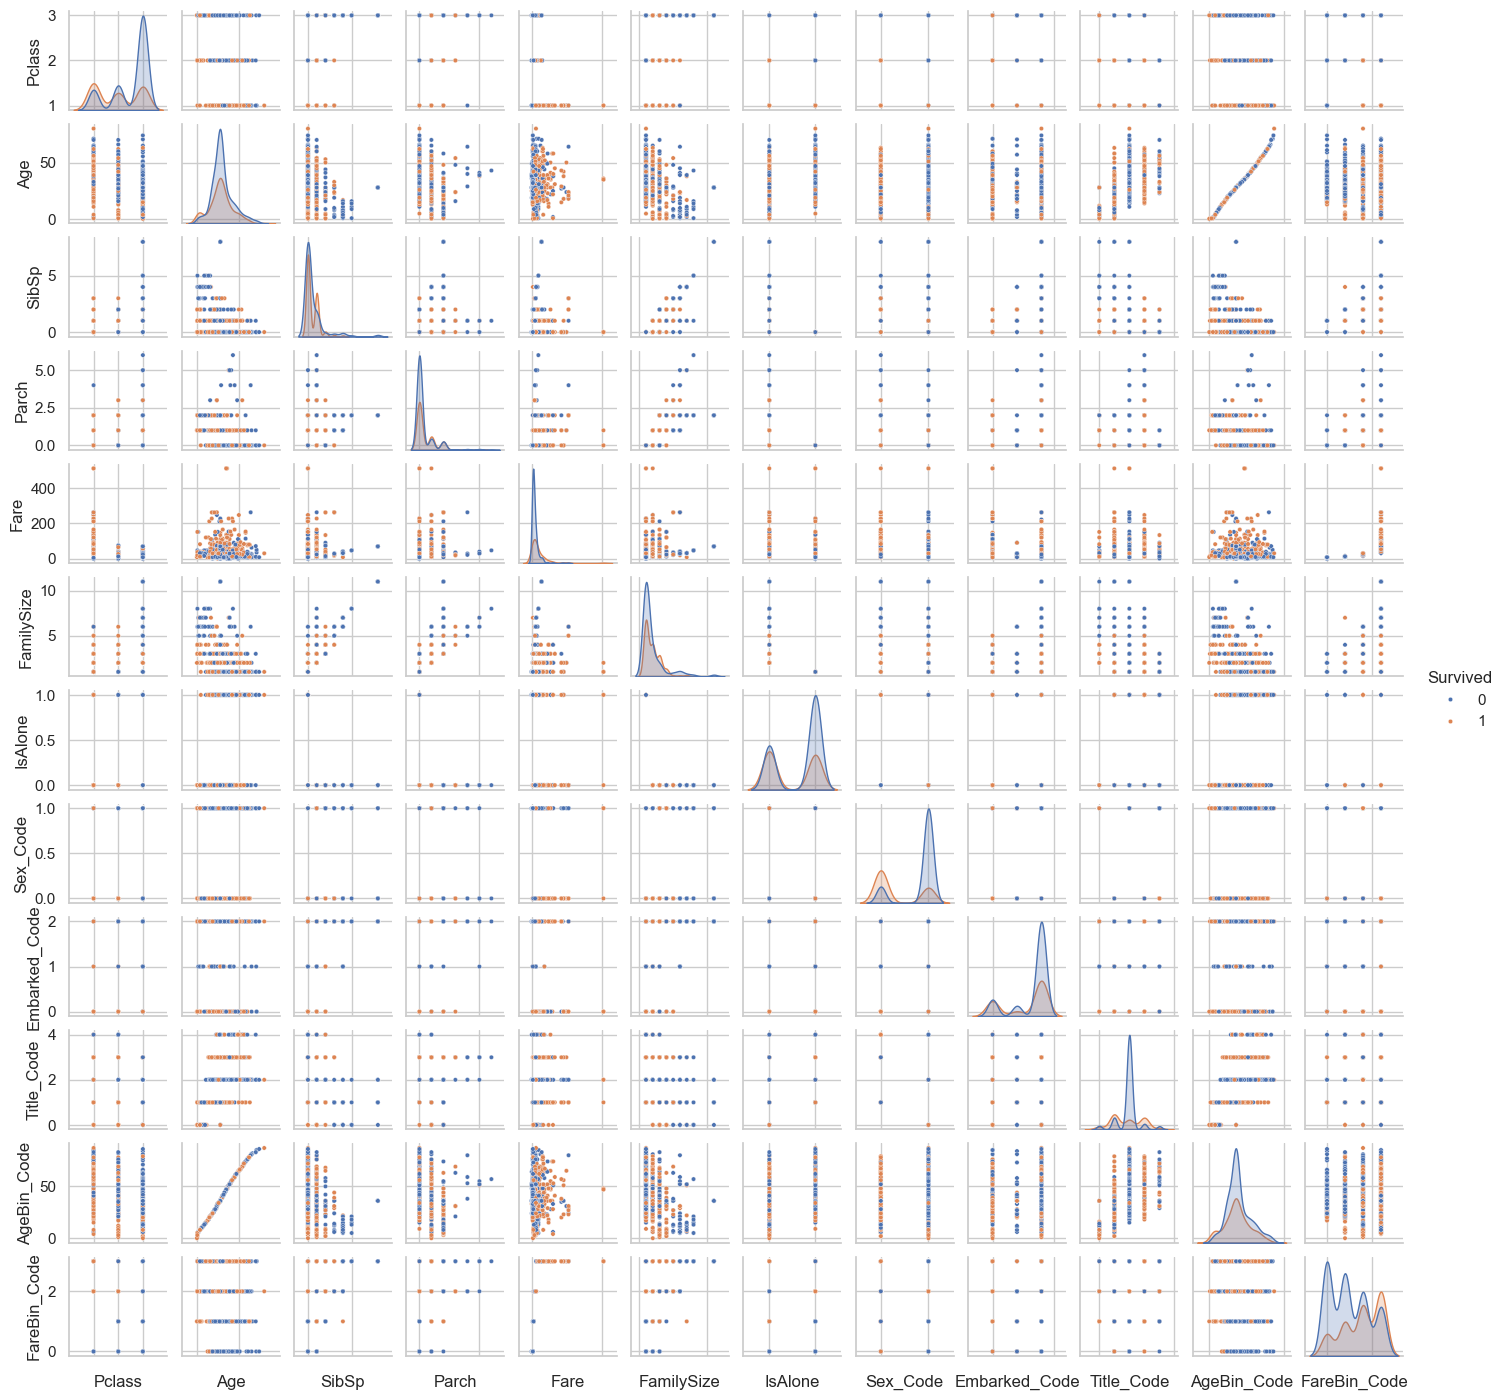

In [66]:
#数値列同士の関係を全て組み合わせて相関を計算
pp = sns.pairplot(data1, hue = 'Survived', palette = 'deep', size=1.2, diag_kind = 'kde', diag_kws=dict(shade=True), plot_kws=dict(s=10) )
pp.set(xticklabels=[])

In [68]:
data1.head(3)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,Title,FareBin,AgeBin,Sex_Code,Embarked_Code,Title_Code,AgeBin_Code,FareBin_Code
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,2,0,Mr,"(-0.001, 7.91]","(16.0, 32.0]",1,2,2,28,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,2,0,Mrs,"(31.0, 512.329]","(32.0, 48.0]",0,0,3,51,3
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,1,1,Miss,"(7.91, 14.454]","(16.0, 32.0]",0,2,1,34,1


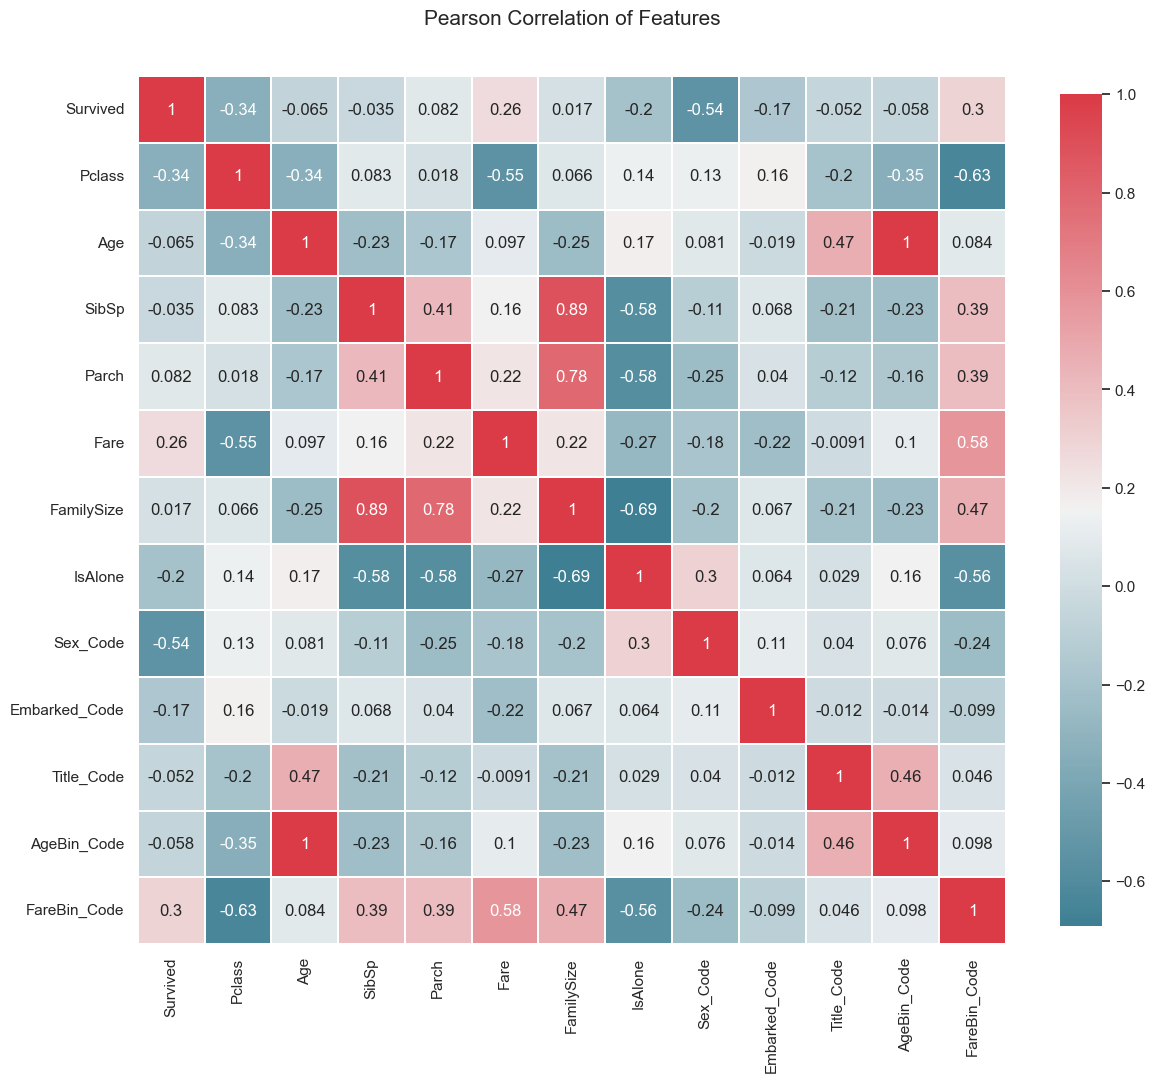

In [ ]:
#ヒートマップを表示したい
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(), #相関係数行列
        cmap = colormap,#色指定
        square=True, #セルを正方形に
        cbar_kws={'shrink':.9 }, #カラーバーを90％に縮小
        ax=ax,
        annot=True, #セルの中身表示
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':12 }#セル内の文字サイズ
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)

correlation_heatmap(data1.select_dtypes(include=['int64','float64']))